# CSCI 3202, Spring 2018

# Friday 6 April 2018

# In-class notebook:  Markov chain Monte Carlo (MCMC)

<a id='top'></a>

<br>

### Your name(s): Austin Argueso-Nott, Jake Tran

<br>

* You will submit this to Moodle as **Quizlet 13**.  
* Be sure to include **everyone's name that you worked with**. 
* Note that **everyone must turn in their own copy of the assignment**.

---

Shortcuts:  [Top](#top) || [Intro](#intro) | [Algorithm](#algo) | [Implementation](#imple) | [Classes](#class) | [Metropolist-Hastings](#mh) | [Inference](#infer) || [Conclusions](#conc)

---

Before we begin, let's load a few packages that we might find useful.

In [23]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

<a id='intro'></a>

---
### Markov chain Monte Carlo

Markov chain Monte Carlo (MCMC) is a common and powerful technique to sample from distributions that are a pain in the ass/impossible to write down explicitly (like, actually do the integrals needed).  Part of the power of MCMC is in its ability to **characterize uncertainty** in the things you are trying to estimate.  Let us have a look, shall we?

<img src="https://www.thesun.co.uk/wp-content/uploads/2017/10/nintchdbpict000357607366.jpg?strip=all&w=960" width="250">


**Suppose we have a linear model** for the number of squirrels we see on a given day ($y$), as a function of the number of miles we ride a bike that day ($x$).  So the ***true*** process model, based on the unknown true values of the slope and intercept parameters, which we can call $\alpha^*$ and $\beta^*$, is:

$$y_{true} = \alpha^* x + \beta^*$$

We can make this more realistic by incorporating some normally-distributed uncertainty, say, with mean 0 and standard deviation $\sigma$.  Call these uncertain measurements $y_{meas}$:

$$y_{meas} = y_{true} + \epsilon = \alpha^* x + \beta^* + \epsilon$$

where $\epsilon \sim N(0, \sigma^2)$ is our normally-distributed measurement error.

Now we want to estimate $\alpha$ and $\beta$.  Call $\hat{\alpha}$ and $\hat{\beta}$ our estimates of these parameters.  They lead to a set of estimates of the response, $\hat{y}$:

$$\hat{y} = \hat{\alpha} x + \hat{\beta}$$

<br>

**To start:**
* set the random number seed so all our results (at least for this part) will be consistent
* set up a grid of $x$ values between 0 and 10 in increments of 0.5, 
* let $\alpha^* = 1$ and let $\beta^* = 10$
* let $\sigma = 1.5$ represent the measurement uncertainty
* calculate the true values $y_{true}$ and a set of measured values $y_{meas}$
* make a plot of:
  * number of miles biked ($x$) versus true number of squirrels seen ($y_{true}$), and
  * measured number of squirrels seen ($y_{meas}$)
  * include axis labels and a legend

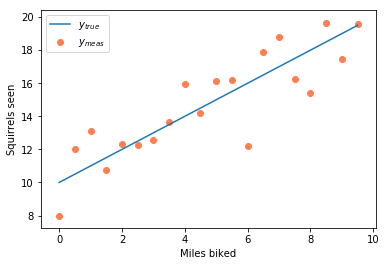

In [24]:
np.random.seed(3202)

astar = 1
bstar = 10
sigma = 1.5
x_grid = np.arange(0,10,0.5)
y_true = [astar*x + bstar for x in x_grid]

# x and y values of our synthetic data set
x_meas = np.arange(0,10,0.5)
y_meas = [stats.norm.rvs(loc=y, scale=sigma) for y in y_true]

plt.plot(x_grid, y_true, label='$y_{true}$')
plt.scatter(x_grid, y_meas, color='coral', label='$y_{meas}$')
plt.xlabel('Miles biked')
plt.ylabel('Squirrels seen')
plt.legend()
plt.show()

**Reflection:**  
1. What do the values $\alpha^* = 1$ and $\beta^* = 10$ mean *physically*?
2. How many data points do we have?

<br>

Of course, we could use good old-fashioned **least squares regression** to get estimates of the parameters $\alpha$ and $\beta$:

In [25]:
bestfit = stats.linregress(x=x_meas, y=y_meas)
print('Slope estimate is {:0.4f}, intercept estimate is {:0.4f}'.format(bestfit.slope,bestfit.intercept))

Slope estimate is 0.9106, intercept estimate is 10.3923


... but that doesn't tell us anything useful about the ***uncertainty*** in those estimates.

*(NB: yes, you could get confidence intervals, but Bayesian estimation and inference are better for real-world decision-making. And Artificial Intelligence is all about teaching computers how to make decisions. So here we go!)*

<br>

So let's use **Markov chain Monte Carlo** to characterize the uncertainty in our estimates of those linear model parameters. To simplify, let's keep $\beta$ fixed at the least square value from above, and only worry about estimating $\alpha$.

In [26]:
beta = bestfit.intercept

<a id='algo'></a>

---
### Algorithm

> **Metropolis-Hastings Algorithm (MCMC):**
  Exactly the same as **simulated annealing** with the following modifications:
  * save **all** of the previous parameter states because it's a Markov chain, so they all tell you something about your system
  * probability of accepting a move at iteration $t$ is the ratio of **posterior scores** for the current and the proposed states:
  $$p_{accept} = \dfrac{\pi(\alpha_{new} \mid y_{meas})}{\pi(\alpha_{t} \mid y_{meas})}$$
  where $\pi(\alpha \mid y_{meas})$ is the posterior score for the parameter value $\alpha$, given the data.
    * if we accept the proposed move, then the next $\alpha_{t+1}$ is set to $\alpha_{new}$
    * if we reject the proposed move, then the next $\alpha_{t+1}$ is set to $\alpha_t$ (no change)
  * do this for some large number $N$ of iterations ($t=0, 1, 2, \ldots, N$)
  
There are a lot of ways to improve and modify the MCMC algorithm, but **this is basically it**.

M-H is just one of many MCMC algorithms, but is the most natural for us to use because of its close ties to simulated annealing.

<br>

**The why:**  If we use $p_{accept}$ as above, then some glorious things occur:
1. the sequence of parameter estimates $\{\alpha_t\}_{t=0}^N$ is a Markov chain (we know this already)
2. math (not shown) reveals that this Markov chain has a stationary distribution...
3. ... that just happens to be **the** posterior distribution $\pi(\alpha \mid y_{meas})$

<a id='imple'></a>

---
### Implementation

To compute the acceptance probabilities for the Metropolis-Hastings algorithm, we need the posterior scores, which are:

$$\text{posterior score} = \pi(\alpha \mid y_{meas}) = L(y_{meas} \mid \alpha) \times \pi(\alpha)$$

So, we will need a likelihood function, $L(y_{meas} \mid \alpha)$, and a prior distribution for $\alpha$, $\pi(\alpha)$.

<br>

#### Likelihood function
For the likelihood function, we know the data are all normally distributed with mean 0 and standard deviation $\sigma$. So, similarly to the SLR model problem from the homework, we will use the product of normal distributions for each data point:

$$L(y \mid \alpha) = \prod_{i=1}^N f(\hat{y}_i-y_i \mid \mu=0, \sigma)$$

where $f(\hat{y}_i-y_i \mid \mu=0, \sigma)$ is a normal pdf evaluated at $\hat{y}_i - y_i$, with mean 0 and standard deviation $\sigma$, and $\hat{y} = \alpha x + \beta$ (evaluated at the `x_grid` points, and with our fixed value for $\beta$) (*hint:  see `scipy.stats.norm.pdf`*)

Code up a `likelihood` function that takes a single argument `parameter` representing the $\alpha$ at which we will evaluate our model to obtain $\hat{y}$ and compare it against $y_{meas}$. Note that this assumes the use of some implicit variables passing into the function, but will keep things a little more tidy.

**"Unit test":** $~~\texttt{likelihood}(1.5) \approx 1.6 \times 10^{-37}$

*If the random number generator seeding is version-dependent, you result might differ. As long as your result is in the ballpark of $10^{-30\text{something}}$, you are probably fine.*

In [27]:
def likelihood(parameter):
    yhat = parameter*x_grid + beta
    collection = stats.norm.pdf(yhat - y_meas, loc = 0, scale = sigma)
    acc = 1
    for i in collection:
        acc = acc * i
    return acc

likelihood(1.5)

1.6245683261075742e-37

#### Prior distribution
The simplest choice for a prior is use a uniform distribution... So let's do that! 

We should use a mechanistic understanding of the system we are studying to inform what the upper and lower bounds of our prior range should be. So condsider:  what is a reasonable lower bound on $\alpha$?

$0 \leq \alpha \leq 5$ seems wide enough to capture anything we care about. Define a `prior` function that takes a single `parameter` argument and returns the prior probability for that parameter value. Again, my hair has gone a little bit gray because of the implicit function input...

**"Unit test":** $~~ \texttt{prior}(1.5) = 0.2$

In [28]:
ub = 5
lb = 0

def prior(parameter):
    if parameter <= ub and parameter >= lb:
        return (1/(ub-lb))
    else:
        return 0

prior(1.5)    

0.2

#### Posterior score
Now for the sake of compactness, define a `posterior` function that returns the posterior score:

$$\texttt{posterior}(\alpha) = \texttt{likelihood}(\alpha) \times \texttt{prior}(\alpha)$$

You can save some run-time by coding the `likelihood` function to only run if the `prior` function returns a nonzero probability.  If `prior`($\alpha$)=0, then we know `posterior`($\alpha$) is going to be 0 no matter what the `likelihood` function returns.  This doesn't matter much for this simple model, but it scales up very nicely.

In [29]:
def posterior(parameter):
    return likelihood(parameter) * prior(parameter)

print("post(-6)", posterior(-6))
print("post(1.5)", posterior(1.5))
print(1.6245683261075742e-37*.2)

post(-6) 0.0
post(1.5) 3.24913665222e-38
3.2491366522151486e-38


**"Unit tests"**:
* What should `posterior(-6)` equal? Check this.
* Check that `posterior(1.5)` = the product of your results above for `likelihood(1.5)` and `prior(1.5)`

Since `posterior` is going to be returning some very small values, in practice we will use the `log(posterior)` values for this algorithm. But **Future You** can worry about that.

<a id='class'></a>

---
### Class structures

#### `State` class from Local Search
Just like for Simulated Annealing (and Hill-Climbing) we should keep track of our states ($\alpha$ values) and the associated posterior scores.

This is just like our Local Search, where now the `posterior` function is our objective function, which we want to maximize. The beauty of MCMC is that we are maximizing it ***in light of the uncertainties in our model and data***.

**Define** an initial parameter estimate for $\alpha$. The least squares regression value for $\alpha$ above is a very reasonable first guess! **And create** an associated initial state for our MCMC algorithm to start from.

In [47]:
class State:
    def __init__(self, state, value):
        self.state = state
        self.value = value

In [48]:
initialState = State(1, posterior(1))

#### `Problem` class... also from Local Search

Below is the code for the Simulated Annealing Problem sub-class, actually copy-pasted from my Local Search notebook and with a couple variable names changed.

**Define** a `ProblemMCMC` object. Use the initial state and `posterior` function from above, and use the stepsize 0.05 to start.

In [49]:
class ProblemMCMC:        
    def __init__(self, initial, posterior, stepsize):
        self.current = initial
        self.post = posterior
        self.stepsize = stepsize
        
    def random_move(self):
        next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        return next_move, self.post(next_move)

In [50]:
mcmcProb = ProblemMCMC(initialState, posterior, 0.05)

<a id='mh'></a>

---
### Metropolis-Hastings algorithm

Below is pseudocode for the Metropolis-Hastings algorithm, which actually *does* the MCMC sampling. The function `mcmc` takes as input a `ProblemMCMC` class object, called `problem`, and a positive integer number of iterations to run the algorithm, `n_iter`.

Fill in the rest of the code!  Your simulated annealing codes can be used as a very helpful guide.

In [51]:
def mcmc(problem, n_iter):
    
    # want to keep growing these lists to track the parameter estimates
    parameters = [problem.current.state]
    posterior = [problem.current.value]
    
    for t in range(n_iter):

        # Propose a new state
        nextMove, movePost = problem.random_move()
        # Calculate the acceptance probability
        p_accept = (movePost/posterior[t])
        # If p_accept >= 1
        if p_accept >= 1:
            # Add the proposed parameter to the end of the list of parameters
            parameters.append(nextMove)
            problem.current.state = nextMove
            # Add the corresponding posterior score to the end of that list too
            posterior.append(movePost)
            problem.current.value = movePost
        # If p_accept < 1
        else:
            # Accept with probability p_accept
            accept = np.random.choice([True, False],p=[p_accept, 1-p_accept])
            # If you accept:
            if accept:
                # Add the proposed parameter to the end of the list `parameters`
                parameters.append(nextMove)
                problem.current.state = nextMove
                # Add the corresponding posterior score to the end of that list too
                posterior.append(movePost)
                problem.current.value = movePost
            # If you reject:
            else:
                # Add another copy of the current parameter value to the end of the list `parameters`
                parameters.append(parameters[t])
                # Add the corresponding posterior score to the end of that list too
                posterior.append(posterior[t])

    return parameters, posterior# the `parameters` and `posterior` scores

**As a first step,** make sure your implementation is working. Run 100 iterations and save the parameter estimates and the corresponding posterior scores.

When plotted as a line, the parameter estimates as a function of iteration should look like the following, which is called a **trace plot** or **history plot** of the Markov chain:

![trace plot](http://www.cs.colorado.edu/~tonyewong/home/resources/example_trace_plot.png)

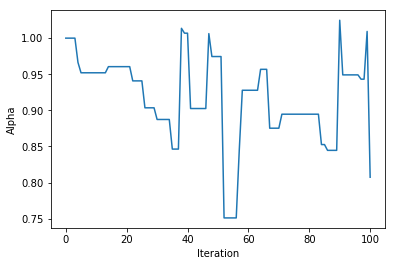

In [52]:
np.random.seed(3202)
n = 100
initialState = State(1, posterior(1))
mcmcProb = ProblemMCMC(initialState, posterior, 0.05)
parameters, posteriorZ = mcmc(mcmcProb, n)

plt.plot(parameters)
plt.xlabel('Iteration')
plt.ylabel('Alpha')
plt.show()

Once you have 100 iterations running smoothly and reproducing (approximately) the plot above, run 4000 iterations and generate a history plot. (*note:  this might take a few seconds*)

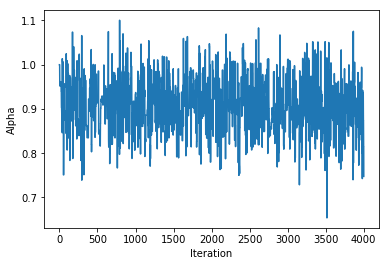

In [53]:
np.random.seed(3202)
n = 4000
initialState = State(1, posterior(1))
mcmcProb = ProblemMCMC(initialState, posterior, 0.05)
parameters, posteriorZ = mcmc(mcmcProb, n)

plt.plot(parameters)
plt.xlabel('Iteration')
plt.ylabel('Alpha')
plt.show()

Your plot should display the **hairy caterpillar** look of a well-mixed Markov chain.  If it's right, you will know it because the history plot will resemble a hairy caterpillar (and Googling 'markov chain hairy caterpillar' will return a lot of appropriate pictures, as well as some cute critters).

#### Acceptance ratio
But another, more sciency, way that we can assess Markov chain quality is by calculating the **acceptance ratio**.  Come up with a way to calculate the proportion of parameter proposals that were accepted.  
* One obvious way is to modify your `mcmc` codes above to return this as an output.
* Another way you can swiftly do this post-processing is to use the `numpy` `diff` function.

**Print out** the acceptance rate for your Markov chain simulation above.

In [55]:
print(np.count_nonzero(np.diff(parameters))/len(parameters))

0.3084228942764309


How do you know if your acceptane ratio is 'correct'?
* For many parameters (think > 10), the optimal acceptance rate is about 23.4%
* For one parameter (our case!), the optimal acceptance rate is about 44%

<br>

The acceptance rate for your Markov chain is almost certainly not 44%.  This is related to the **stepsize** used:
* if you accept too few proposals, then your stepsize is too large (because you're leaping over good ones)
* if you accept too many proposals, then your stepsize is too small (because you are too timid in your exploration)

**Play around** with the `stepsize` input to the `ProblemMCMC` object and see if you can get something closer to 44%. 

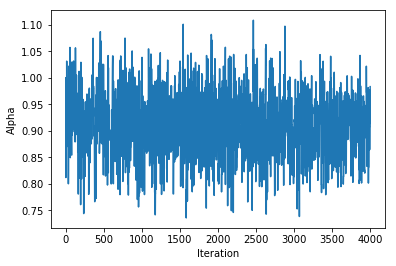

0.4461384653836541


In [38]:
np.random.seed(3202)
n = 4000
initialState = State(1, posterior(1))
mcmcProb = ProblemMCMC(initialState, posterior, 0.02)
parameters, posteriorZ = mcmc(mcmcProb, n)

plt.plot(parameters)
plt.xlabel('Iteration')
plt.ylabel('Alpha')
plt.show()

print(np.count_nonzero(np.diff(parameters))/len(parameters))

<a/ id='infer'></a>

---
### Posterior inference
Now that our acceptance rate is about right, we can use the resulting Markov chain to make inferences regarding the parameter $\alpha$.

We only care about the Markov chain once it has converged to the **stationary distribution** though, which takes some time.  So we need to throw away the period during which it is still converging.  This process is called **burn-in**.

Throw out the first half of your Markov chain for burn-in, and save the last half (2000 iterations) for analysis.

In [39]:
newparameters = parameters[-2000:]

#### Histograms
... are one way to ***qualitatively*** display and characterize uncertainty in our model parameter.  Make a histogram of our posterior parameter estimates for $\alpha$.

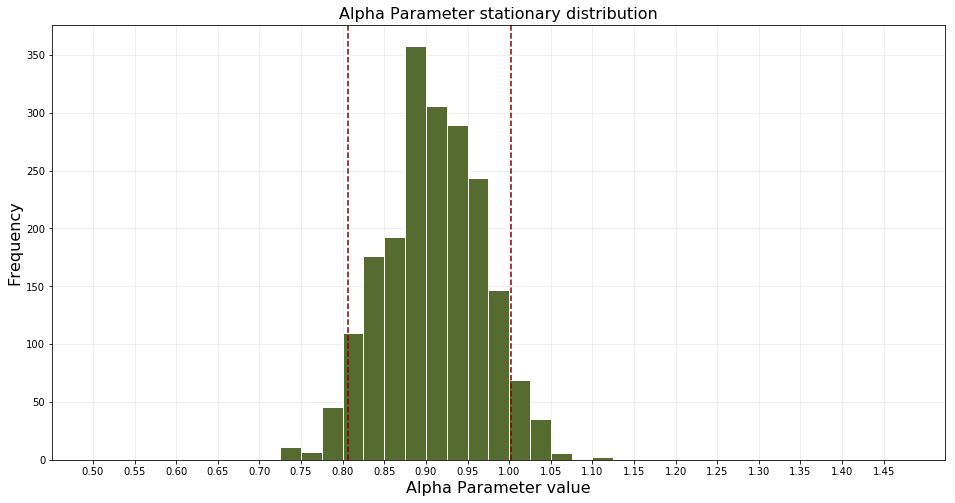

In [40]:
%matplotlib inline

l = np.percentile(newparameters, 5)
u = np.percentile(newparameters, 95)
    
ci = np.array([l, u])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
ax.hist(newparameters, bins = np.arange(0.5,1.5,0.025), facecolor="darkolivegreen", edgecolor="ivory")
ax.set_ylabel('Frequency', fontsize=16)
ax.set_xlabel('Alpha Parameter value', fontsize=16)
ax.set_title("Alpha Parameter stationary distribution", fontsize=16)
ax.grid(alpha=0.25)
ax.set_xticks(np.arange(0.5,1.5,0.05))
for i in ci:
        ax.axvline(x=i, color='maroon', linestyle='--',)
ax.set_axisbelow(True)

#### Credible intervals
... are a way to ***quantitatively*** characterize our parametric uncertainty.  Calculate and print to the screen the 90% credible interval, which is the 5-95% quantile range.

In [41]:
print(ci)

[ 0.80647189  1.00250423]


#### Projections

It is possible that you would use MCMC to characterize uncertainty and that would be it.  But another big strength of MCMC is our ability now to generate a **posterior ensemble** and use it to make projections out-of-sample.  For example, our data did not include any bike rides longer than 10 miles.  So a natural question is: *what is our best estimate for the number of squirrels we would see on a 15-mile bike ride?* and equally importantly: *what is the uncertainty in that estimate?*

**Estimate** the number of squirrels you would see on a 15-mile bike ride using the 2000 posterior samples for $\alpha$.
* create a histogram of your estimates of $y(15)$
* calculate and print the 5-95% credible range for $y(15)$

[ 22.48935208  25.4298371 ]


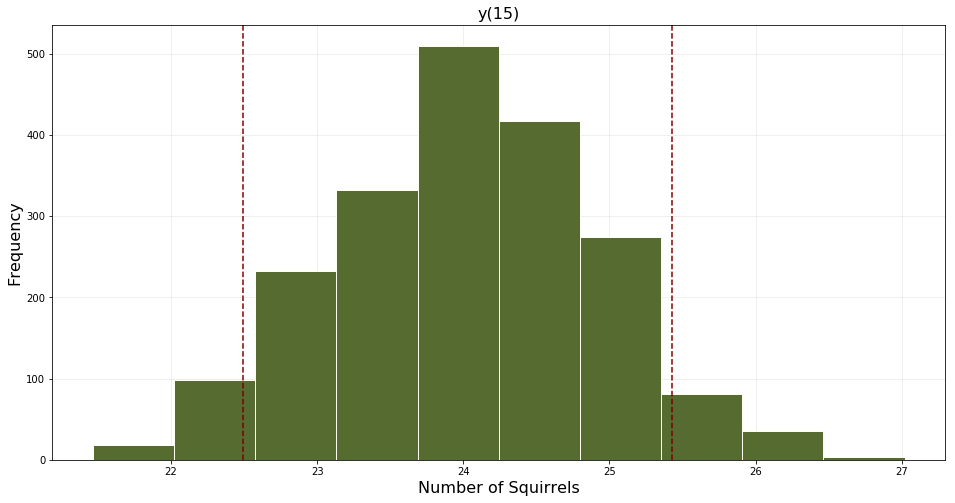

In [42]:

newY = (np.array(newparameters)*15) + beta
lY = np.percentile(newY, 5)
uY = np.percentile(newY, 95)
    
ciY = np.array([lY, uY])
print(ciY)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
ax.hist(newY, facecolor="darkolivegreen", edgecolor="ivory")
ax.set_ylabel('Frequency', fontsize=16)
ax.set_xlabel('Number of Squirrels', fontsize=16)
ax.set_title("y(15)", fontsize=16)
ax.grid(alpha=0.25)
for i in ciY:
        ax.axvline(x=i, color='maroon', linestyle='--',)
ax.set_axisbelow(True)

<a/ id='conc'></a>

---
### Important take-aways:

1. The Metropolis-Hasting MCMC algorithm is just simulated annealing done in a clever way...
2. that allows us to sample from the **posterior distribution** of model parameters, **given the data**.
6. Acceptance rate of about 23% is optimal only for lots parameters. For our single parameter, it's more like 44%.
4. We can use MCMC and credible intervals/histograms to **characterize** and **quantify** uncertainty in both our parameters and predictions.

<br>

[Back to top](#top)